In [1]:
import params
import model
import matplotlib.pyplot as plt
import jax
import jax.numpy as np

In [2]:
# # simulation
# tissue_size = (12, 12)  #cm
# dx = 0.03  # (cm/dx) Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03)
# dt = 0.01  # (ms) Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)
# shape = (int(tissue_size[0] / dx), int(tissue_size[1] / dx))  # (dx)
# d = 0.05  # (cm^2/ms)
# cell_parameters = params.params_test()

# # scale parameters
# # d = params.scale_diffusivity(d, dt, dx)  # (dx^2 / dt)
# # cell_parameters = params.scale(cell_parameters, dt, dx)

# # stimuli
# stimulated = int(shape[0] / 5)
# field1 = np.zeros(shape)
# field1 = jax.ops.index_update(field1, jax.ops.index[0:stimulated], .8)
# s1 = {
#     "field": field1,
#     "start": 0,
#     "duration": 2,
#     "period": 0  # non-cyclic
# }

# print(shape)
# model.show_stimuli(s1, s1)
# print(cell_parameters)

(120, 120)
real tissue size: (1200.0, 1200.0)


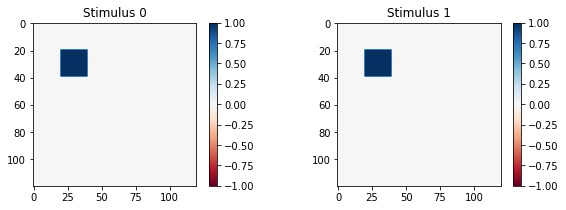

{'Cm': 1, 'V_c': 0.16, 'V_v': 0.16, 'tau_d': 0.125, 'tau_v1_minus': 82.5, 'tau_v2_minus': 60, 'tau_v_plus': 5.75, 'tau_0': 32.5, 'tau_r': 70, 'tau_si': 114, 'V_csi': 0.85, 'k': 10, 'tau_w_minus': 400, 'tau_w_plus': 300, 'D': 0.05}


In [43]:
# simulation
dx = 0.1
dt = 0.01  # (ms) Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)
shape = (120, 120)
d = 0.05  # (cm^2/ms)
cell_parameters = params.params_test()

# stimuli
stimulated = int(shape[0] / 5)
field1 = np.zeros(shape)
field1 = jax.ops.index_update(field1, jax.ops.index[20:40, 20:40], 1.)
s1 = {
    "field": field1,
    "start": 0,
    "duration": 2,
    "period": 0  # non-cyclic
}

print(shape)
print("real tissue size:", (shape[0]/dx, shape[1]/dx))
model.show_stimuli(s1, s1)
print(cell_parameters)

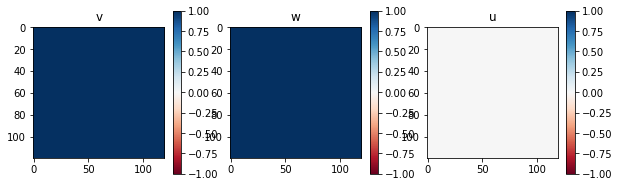

In [44]:
state = model.init(shape)
t = 0
model.show(state)

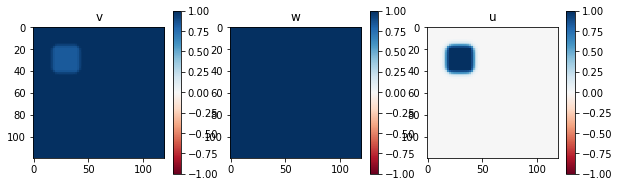

In [45]:
state = model._forward(state, 0, 100, cell_parameters, np.ones(shape) * d, [s1], dt, dx)
model.show(state)

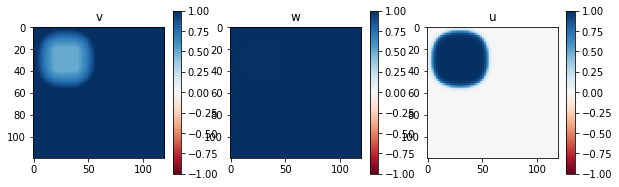

In [46]:
state = model._forward(state, 101, 400, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 500
model.show(state)

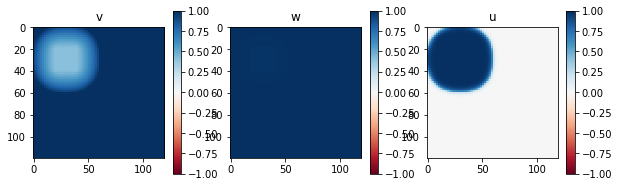

In [47]:
state = model._forward(state, 401, 500, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 1000
model.show(state)

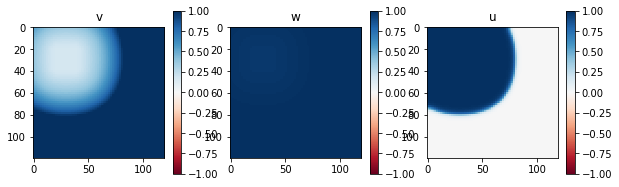

In [48]:
state = model._forward(state, 501, 1000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)   # dt = 1500
model.show(state)

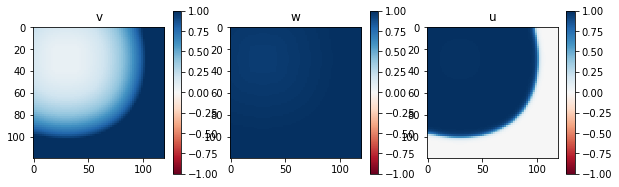

In [49]:
state = model._forward(state, 1001, 1500, cell_parameters, np.ones(shape) * d, [s1], dt, dx)   # dt = 2000
model.show(state)

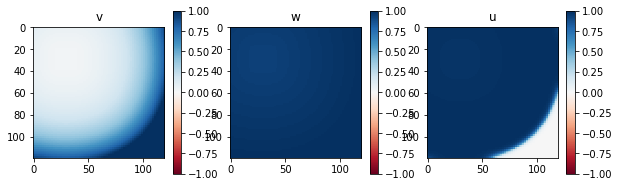

In [50]:
state = model._forward(state, 1501, 2000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)   # dt = 2500
model.show(state)

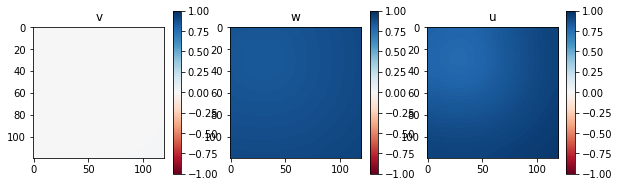

In [51]:
state = model._forward(state, 2001, 5000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 5000
model.show(state)

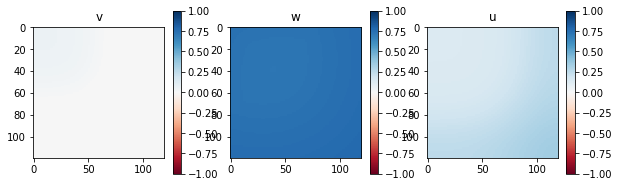

In [52]:
state = model._forward(state, 5001, 10000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 10000
model.show(state)

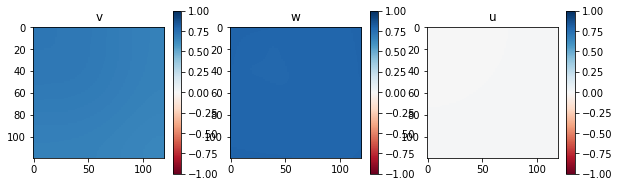

In [53]:
state = model._forward(state, 10001, 20000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 10000
model.show(state)

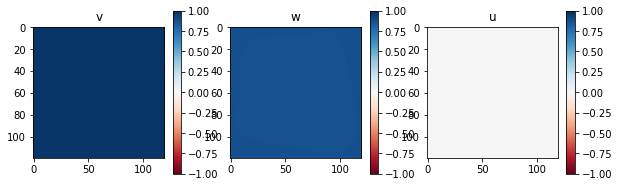

In [54]:
state = model._forward(state, 20001, 40000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 10000
model.show(state)

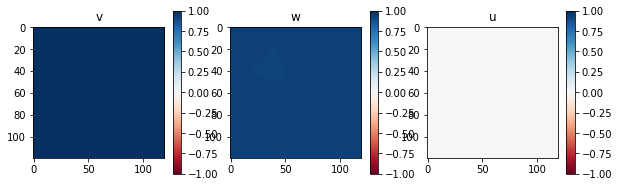

In [55]:
state = model._forward(state, 40001, 64000, cell_parameters, np.ones(shape) * d, [s1], dt, dx)  # dt = 10000
model.show(state)